In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time
import itertools
import threading
threading.stack_size(67108864)

0

# Minimum Feedback Vertex Set Problem (NP-complete Problem)

A feedback vertex set of a graph is a set of vertices whose removal leaves a graph without cycles. The minimum feedback vertex set problem is an NP-complete problem. The problem is stated as follow:

Given an undirected graph $G=(V,E)$, find a smallest set of vertices such that removing them from the graph makes it acyclic (a forest).

Note: There is also a directed graph version of this problem but for this project, it will focuses on undirected graph.

Minimum Feedback Vertex Set Problem is used in the study of deadlock recovery. Each cycle is the deadlock situation that we are trying to solve and that the minimum feedback vertex set is the minimum number of processes that needs to be abort.

In this project, we will study both exact and approximation algorithms to solve for minimum feedback vertex set in an undirected graph.


# Naive Solution

The naive solution for the Minimum Feedback Vertex Set (MFVS) problem involves generating all subsets of vertices and checking if the removal of those vertices results in an acyclic graph. 

The algorithm can be broken down into two main steps:

1. **Cycle Detection**: The algorithm uses Depth First Search (DFS) to determine whether the given graph is acyclic. The worst-case running time for DFS is $O(V+E)$, where $V$ is the number of vertices and $E$ is the number of edges in the graph.

2. **Subset Generation**: The algorithm generates all possible subsets of vertices within the graph $G$. If the graph $G-S$ is found to be acyclic for a subset $S \subseteq G$, the algorithm returns immediately. The running time for generating all subsets is $O(2^V)$, as there are $2^V$ possible subsets of $V$ vertices.

Therefore, the overall worst-case running time of this naive algorithm is $O(2^V \cdot (V+E))$. This is because for each subset, the algorithm performs a DFS to check if the graph is acyclic.

In [3]:
# Plot a graph
def draw_graph(G):
    nx.draw(G, with_labels=True)
    plt.show()

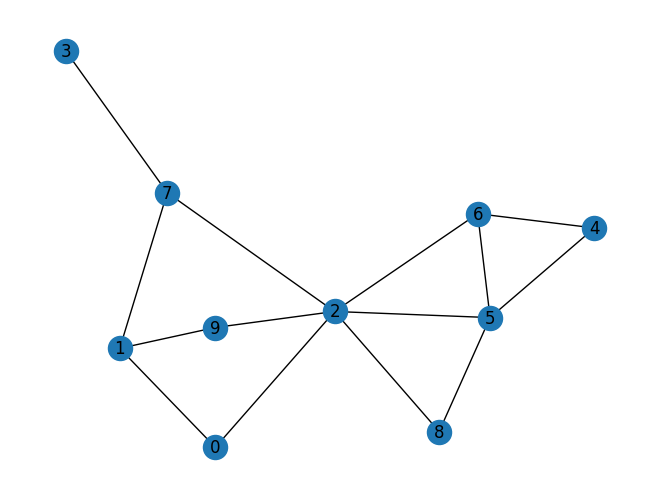

Removed vertices: {1, 5}
Remaining vertices: [0, 2, 3, 4, 6, 7, 8, 9]


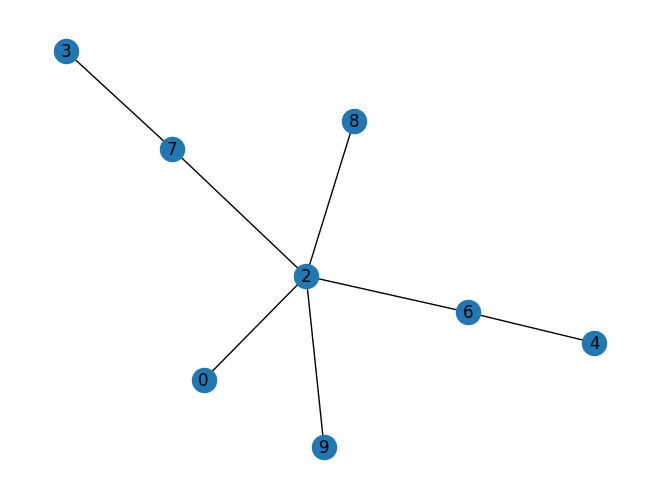

In [6]:
# Check if graph is acyclic
# Running time: O(V + E)
def is_acyclic_graph(G):
    visited = set()
    def dfs(node, parent):
        visited.add(node)
        for neighbor in G.neighbors(node):
            if neighbor != parent:
                if neighbor in visited:
                    return False
                if not dfs(neighbor, node):
                    return False
        return True
    for node in G.nodes():
        if node not in visited:
            if not dfs(node, None):
                return False
    return True
    
# Naive algorithm to find a minimum feedback vertex set
# Running time: O(2^V * (V + E))
def naive_fvs(G):
    if is_acyclic_graph(G):
        return set(), 0
    for i in range(1, len(G.nodes()) + 1):
        for subset in itertools.combinations(G.nodes(), i):
            G_copy = G.copy()
            G_copy.remove_nodes_from(subset)
            if is_acyclic_graph(G_copy):
                return set(subset), len(subset)
    return None, np.inf

# Generate Random Undirected Graph
G = nx.erdos_renyi_graph(10, 0.3)
draw_graph(G)   
smallest_subset, smallest_fvs = naive_fvs(G)
G.remove_nodes_from(smallest_subset)
print("Removed vertices: " + str(smallest_subset))
print("Remaining vertices: " + str(G.nodes()))
draw_graph(G)

# Local-Ratio Feedback Vertex Set Algorithm (3-Approximation Algorithm)

The LR-FVS algorithm is an algorithm designed to approximate solutions for the minimum Feedback Vertex Set (FVS) problem. The basic principle behind this algorithm is using the local ratio method, which involves breaking complex problems into simpler subproblems, solving these subproblems, and then combining the solutions of the subproblems to form a solution for the original problem. The algorithm also makes use of the idea that Minimum Feedback Vertex Set cannot have a vertex $v$ where $deg(v) < 2$.

Definition:

Clean Graph: A graph without vertex $v$ where $deg(v) < 2$. Graph without leaf and isolated vertex.

The Local Ratio Method can be applied in LR-FVS as follows:

1. The algorithm calculated the minimum ratio between the cost and degree of a vertex - 1.

2. The algorithm breaks down the problem into two subproblems. One subproblem involves finding the ratio as mentioned in the previous step and calculating the next cost function to be used in the next iteration. Another subproblem is that it uses the old cost function and the new cost function to determine which vertex to exclude from the graph, thus breaking down the problem. After solving, the algorithm combines all the solutions into one.



Suppose the size of exact solution of minimum Feedback Vertex Set is $k$ and solution of LR-FVS is $s$. The size of the approximated solution provided by LR-FVS is within this $k \leq s \leq 3k$. 

Although the output of this algorithm does not give out optimal solution, it is significantly faster and it is no longer running in exponential time.
$$T(V)=O(V^2) + T(V-1)=O(V^3)$$
The algorithm worst-case is $O(V^3)$ since it have to copy the graph and supposedly that every iteration removes only single vertex.




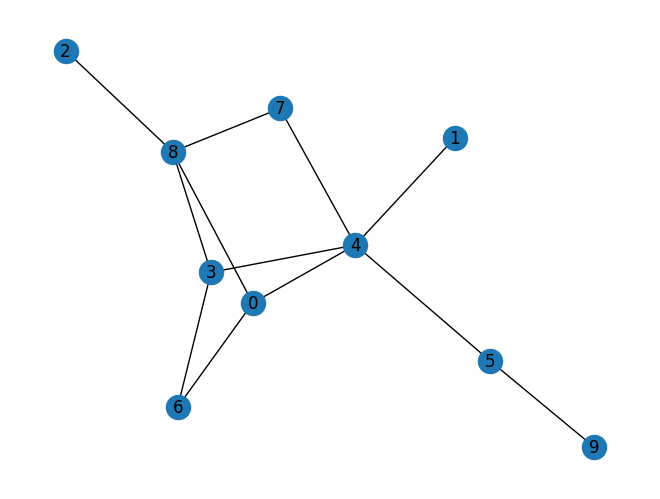

Time taken by naive algorithm:  0.0
Time taken by Igor Razgon algorithm:  0.0
Naive algorithm removed vertices: {0, 3} Size:  2
3-Approximation algorithm removed vertices: {0, 8, 3, 4} Size:  4
Remaining vertices after naive algorithm: [1, 2, 4, 5, 6, 7, 8, 9]
Remaining vertices after 3-Approximation algorithm: [1, 2, 5, 6, 7, 9]


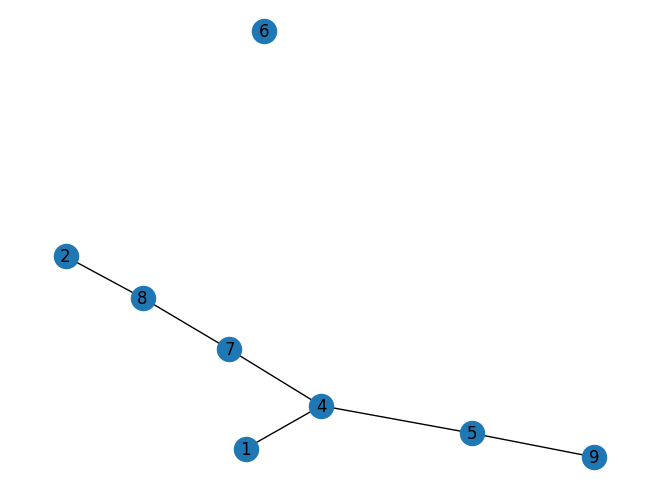

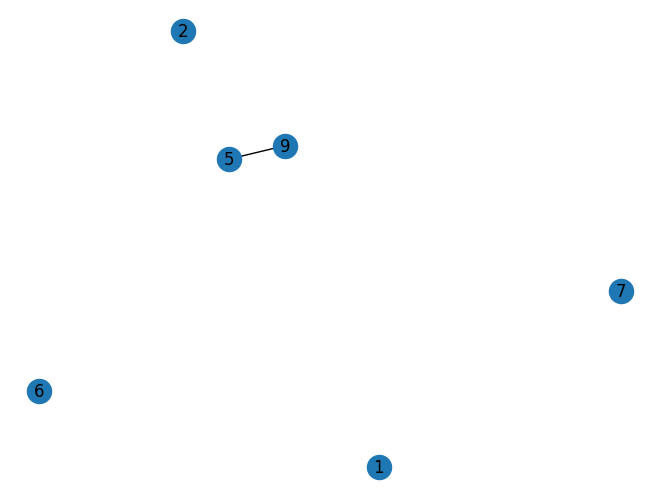

In [16]:
# Clean the graph by removing vertices with degree <= 1
# Running time: O(V^2)
def clean(graph):
    while any([len(graph[v]) <= 1 for v in graph]):
        for v in graph:
            if len(graph[v]) <= 1:
                graph.remove_node(v)
                break
    return graph

# Recursive helper function for Local Ration algorithm
def fvs_helper(graph, cost_vertices):
    graph = clean(graph)
    if len(graph) == 0:
        return set(), 0
    a = min(cost_vertices[v]/(graph.degree[v]-1) for v in graph.nodes())
    new_cost_vertices = {v: a*(graph.degree[v]-1) for v in graph.nodes()}
    subset = {v for v in graph.nodes() if cost_vertices[v] == new_cost_vertices[v]}
    new_graph = graph.copy()
    new_graph.remove_nodes_from(subset)
    rec_subset, rec_size = fvs_helper(new_graph, new_cost_vertices)
    return subset.union(rec_subset), len(subset) + rec_size

# Local Ration algorithm to find a minimum feedback vertex set (Approximation)
# Running time: O(V^3)
def lr_fvs(graph):
    graph_copy = graph.copy()
    clean_graph = clean(graph_copy)
    cost_vertices = {v: 1/(clean_graph.degree[v]-1) for v in clean_graph}
    fvs, fvs_size = fvs_helper(clean_graph, cost_vertices)
    return fvs, fvs_size

# Generate random graph
G = nx.erdos_renyi_graph(10, 0.3)
G_copy1 = G.copy()
G_copy2 = G.copy()
draw_graph(G)

# Measure time for naive_fvs
start_time = time.time()
smallest_subset, smallest_fvs = naive_fvs(G)
end_time = time.time()
print("Time taken by naive algorithm: ", end_time - start_time)

# Measure time for lr_fvs
start_time = time.time()
lr_fvs_subset, lr_fvs_size = lr_fvs(G)
end_time = time.time()
print("Time taken by Igor Razgon algorithm: ", end_time - start_time)

# Remove feedback vertex set from the graph
G_copy1.remove_nodes_from(smallest_subset)
G_copy2.remove_nodes_from(lr_fvs_subset)

print("Naive algorithm removed vertices: " + str(smallest_subset), "Size: ", smallest_fvs)
print("3-Approximation algorithm removed vertices: " + str(lr_fvs_subset), "Size: ", lr_fvs_size)

print("Remaining vertices after naive algorithm: " + str(G_copy1.nodes()))
print("Remaining vertices after 3-Approximation algorithm: " + str(G_copy2.nodes()))

draw_graph(G_copy1)
draw_graph(G_copy2)


# Improved Local Ratio Feedback Vertex Set Algorithm (2-Approximation Algorithm)

This proposed algorithm by Balfa et al, is an extended version of the original LR-FVS that ensures that the result FVS is within $k \leq s \leq 2k$.

Definition:

Semi-disjoint cycle: A cycle with one and only one vertex $v$ with $deg(v) > 2$.

In this version, the running time is approximately $O(V^3C)$ where $V$ is the number of vertices and $C$ is the number of cycles. This running time is slighly larger compared to the $3$-approximation algorithm since we have to check whether the graph contains a semi-disjoint cycle every iteration but it ensures better approximation.

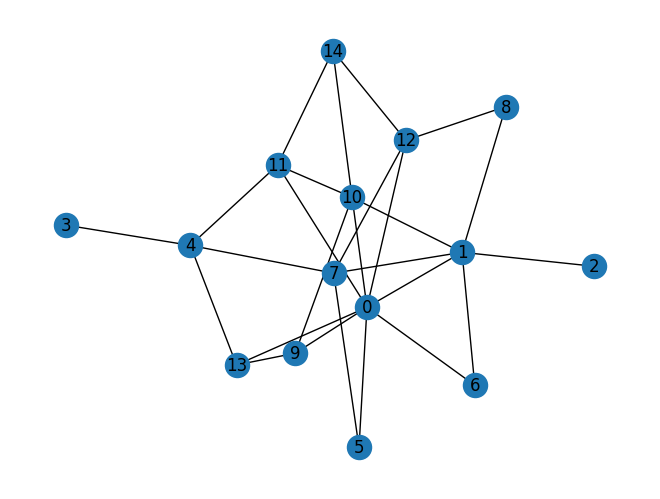

Time taken by naive algorithm:  0.033301591873168945
Time taken by LR_FVS:  0.0
Time taken by LR-FVS-mod:  0.008011341094970703
Naive algorithm removed vertices: {0, 10, 7} Size:  3
LR-FVS algorithm removed vertices: {0, 8, 4, 14} Size:  4
LR-FVS-mod algorithm removed vertices: {0, 8, 4, 14} Size:  4


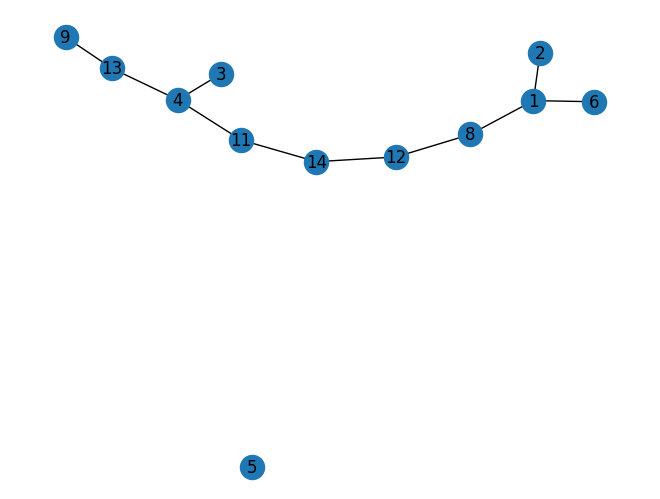

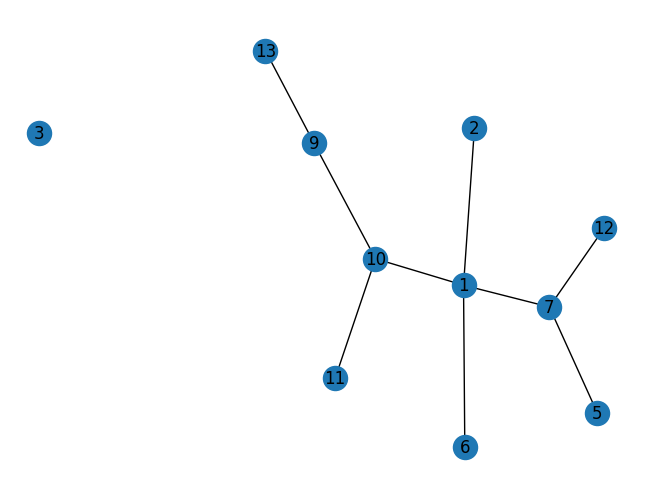

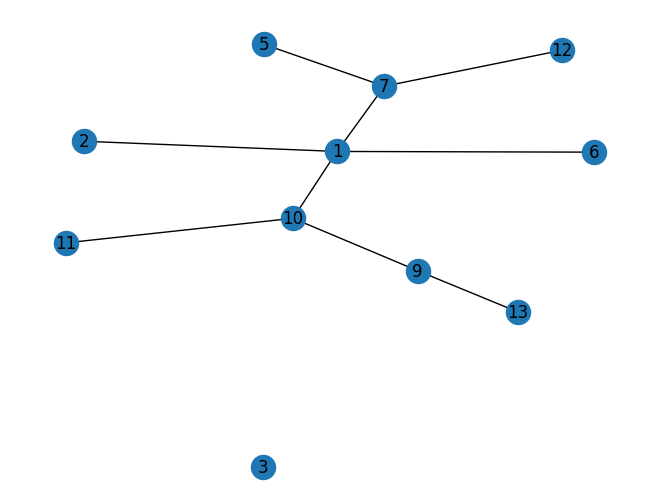

In [5]:
# Check if the graph contains a semi-disjoint cycle
# Running time: O(V^2*C)
def contain_semi_disjoint_cycle(graph):
    for node in graph.nodes():
        cycles = nx.cycle_basis(graph.subgraph(nx.node_connected_component(graph, node)))
        for cycle in cycles:
            if is_semi_disjoint_cycle(graph, cycle):
                return True, cycle
    return False, None

# Check if the given cycle is semi-disjoint
# Running time: O(V) where V is the number of vertices in the cycle
def is_semi_disjoint_cycle(graph, cycle):
    high_degree_count = sum(1 for node in cycle if graph.degree(node) > 2)
    return high_degree_count == 1

# Local Ration algorithm to find a minimum feedback vertex set (2-Approximation)
# Running time: O(V^3C)
def lr_fvs_mod_helper(graph, cost_vertices):
    graph = clean(graph)
    if len(graph) == 0:
        return set()
    contain, cycle = contain_semi_disjoint_cycle(graph)
    if contain:
        print("Cycle: ", cycle)
        u = max(cycle, key=lambda v: graph.degree[v])
        min_cost = min(cost_vertices[v] for v in cycle)
        u_min = [v for v in cycle if cost_vertices[v] == min_cost][0]

        for v in cycle:
            cost_vertices[v] -= min_cost
        
        all_vertices_except_u = [c for c in cycle if c != u]
        graph.remove_nodes_from(all_vertices_except_u)
        fvs = lr_fvs_mod_helper(graph, cost_vertices)
        return fvs.union({u_min})
    else:
        a = min(cost_vertices[v]/(graph.degree[v]-1) for v in graph.nodes())
        new_cost_vertices = {v: a*(graph.degree[v]-1) for v in graph.nodes()}
        subset = {v for v in graph.nodes() if cost_vertices[v] == new_cost_vertices[v]}
        new_graph = graph.copy()
        new_graph.remove_nodes_from(subset)
        rec_subset = lr_fvs_mod_helper(new_graph, new_cost_vertices)
        return subset.union(rec_subset)
        
def lr_fvs_mod(G):
    G_copy = G.copy()
    clean_graph = clean(G_copy)
    cost_vertices = {v: 1/(clean_graph.degree[v]-1) for v in clean_graph}
    fvs = lr_fvs_mod_helper(clean_graph, cost_vertices)
    return fvs, len(fvs)

# Generate random graph
G = nx.erdos_renyi_graph(15, 0.25)
G_copy1 = G.copy()
G_copy2 = G.copy()
G_copy3 = G.copy()
draw_graph(G)

# Measure time for lr_fvs_mod
start_time = time.time()
naive_subset, naive_fvs_set = naive_fvs(G_copy1)
end_time = time.time()
print("Time taken by naive algorithm: ", end_time - start_time)
start_time = time.time()
lr_fvs_set, lr_fvs_size = lr_fvs(G_copy2)
end_time = time.time()
print("Time taken by LR_FVS: ", end_time - start_time)
end_time = time.time()
start_time = time.time()
mod_subset, mod_fvs_size = lr_fvs_mod(G_copy3)
end_time = time.time()
print("Time taken by LR-FVS-mod: ", end_time - start_time)

# Remove feedback vertex set from the graph
G_copy1.remove_nodes_from(naive_subset)
G_copy2.remove_nodes_from(lr_fvs_set)
G_copy3.remove_nodes_from(mod_subset)

print("Naive algorithm removed vertices: " + str(naive_subset), "Size: ", naive_fvs_set)
print("LR-FVS algorithm removed vertices: " + str(lr_fvs_set), "Size: ", lr_fvs_size)
print("LR-FVS-mod algorithm removed vertices: " + str(mod_subset),  "Size: ", mod_fvs_size)

draw_graph(G_copy1)
draw_graph(G_copy2)
draw_graph(G_copy3)

# Greedy Algorithm (My attempt)

The goal of this greedy algorithm is to find the Minimum Feedback Vertex Set by removing a vertex such that it appears the most in all cycles. The algorithm makes use of idea to quickly remove the vertex such that it deletes the most cycles.

Running time Analysis:
Let $V$ be the number of vertices, $E$ be the number of edges and $C$ be the number of cycles.

At each iteration, the algorithm searches for all cycles in a graph $O(V+E)$. Next, it find the most occurring vertex in all cycles $O(VC)$. It then clean the graph $O(V^2)$. At most, there can be $V-2$ iteration as the graph we are analyzing is an undirected simple graph. Thus, the running time of the whole algorithm is
$O(V^3+V^2+VE+V^2C)$ which is approximately $O(V^3)$.

Note: This greedy algorithm does not ensure optimal solution but it does give a good-enough solution.

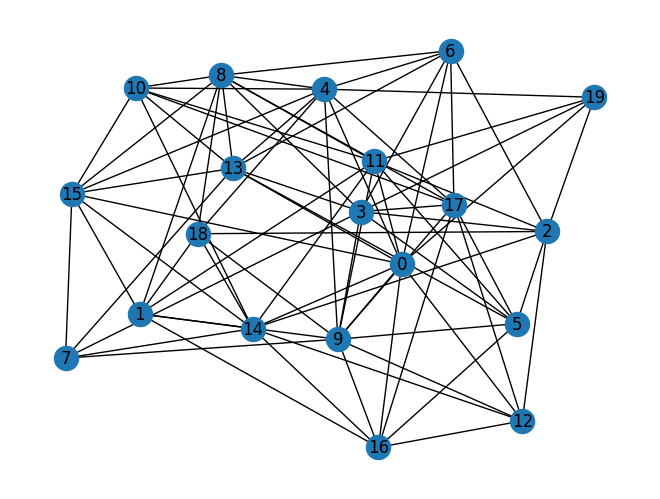

Time taken by Greedy algorithm:  0.0030443668365478516
Time taken by naive algorithm:  122.25912475585938
Greedy algorithm removed vertices: {0, 3, 4, 5, 8, 9, 11, 14, 15, 16, 17} Size:  11
Naive algorithm removed vertices: {0, 1, 2, 3, 4, 8, 9, 13, 14, 17} Size:  10


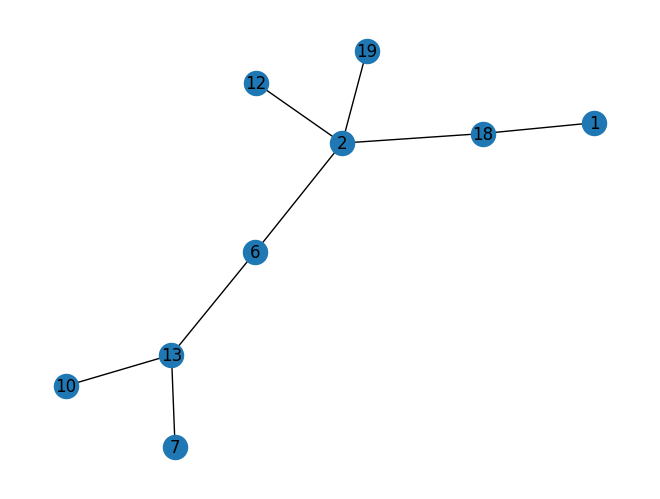

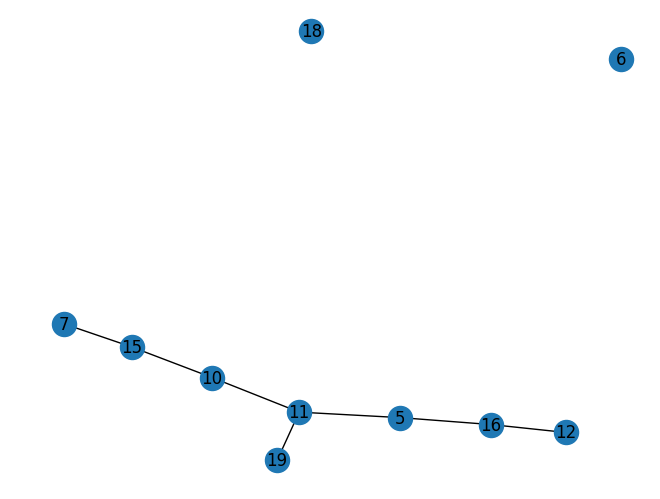

In [6]:
# Function to find the occurring vertex in the cycles
# Running time: O(VC) where V is the number of vertices and C is the number of cycles
def most_weighted_vertices(cycles):
    occurence = {}
    for cycle in cycles:
        for vertex in cycle:
            if vertex in occurence:
                occurence[vertex] += 1
            else:
                occurence[vertex] = 1
    return max(occurence, key=occurence.get)

# Greedy algorithm to find a minimum feedback vertex set
# Running time: O(V^3C)
def greedy_fvs(G):
    if G.nodes() == 0:
        return set(), 0
    G = G.copy()
    fvs_set = set()
    clean(G)
    while (not is_acyclic_graph(G)):
        cycles = nx.cycle_basis(G)
        v = most_weighted_vertices(cycles)
        G.remove_node(v)
        fvs_set.add(v)
        clean(G)
    return fvs_set, len(fvs_set)

# Generate random graph
G = nx.erdos_renyi_graph(20, 0.45)
G_copy1 = G.copy()
G_copy2 = G.copy()
draw_graph(G)

# Measure time for greedy_fvs
start_time = time.time()
greedy_subset, greedy_fvs_size = greedy_fvs(G_copy1)
end_time = time.time()
print("Time taken by Greedy algorithm: ", end_time - start_time)
start_time = time.time()
naive_subset, naive_fvs_size = naive_fvs(G_copy2)
end_time = time.time()
print("Time taken by naive algorithm: ", end_time - start_time)

# Remove feedback vertex set from the graph
G_copy1.remove_nodes_from(greedy_subset)
G_copy2.remove_nodes_from(naive_subset)

print("Greedy algorithm removed vertices: " + str(greedy_subset), "Size: ", greedy_fvs_size)
print("Naive algorithm removed vertices: " + str(naive_subset), "Size: ", naive_fvs_size)

draw_graph(G_copy1)
draw_graph(G_copy2)

# Testing the accuracy and the average running time of the algorithms.

In [7]:
def test(size, times):
    Greedy_time = set()
    Greedy_accuracy = set()
    LR_time = set()
    LR_accuracy = set()
    LR_mod_time = set()
    LR_mod_accuracy = set()
    for _ in range(times):
        random_probability = round(np.random.uniform(0.3, 1), 2)
        G = nx.erdos_renyi_graph(size, random_probability)

        G_copy1 = G.copy()
        G_copy2 = G.copy()
        G_copy3 = G.copy()

        _, naive_fvs_size = naive_fvs(G)
        if naive_fvs_size == 0:
            times += 1
            continue

        start_time = time.time()
        _, greedy_fvs_size = greedy_fvs(G_copy1)
        end_time = time.time()

        Greedy_time.add(end_time - start_time)
        Greedy_accuracy.add(greedy_fvs_size/naive_fvs_size)

        start_time = time.time()
        _, lr_fvs_size = lr_fvs(G_copy2)
        end_time = time.time()

        LR_time.add(end_time - start_time)
        LR_accuracy.add(lr_fvs_size/naive_fvs_size)

        start_time = time.time()
        _, mod_fvs = lr_fvs_mod(G_copy3)
        end_time = time.time()

        LR_mod_time.add(end_time - start_time)
        LR_mod_accuracy.add(mod_fvs/naive_fvs_size)

    print("Greedy algorithm:")
    
    print("Average time: ", np.mean(list(Greedy_time)))
    print("Average accuracy: ", np.mean(list(Greedy_accuracy)))

    print("LR algorithm:")

    print("Average time: ", np.mean(list(LR_time)))
    print("Average accuracy: ", np.mean(list(LR_accuracy)))
          
    print("LR-mod algorithm:")

    print("Average time: ", np.mean(list(LR_mod_time)))
    print("Average accuracy: ", np.mean(list(LR_mod_accuracy)))

test(15, 1000)

Greedy algorithm:
Average time:  0.0010048429409186997
Average accuracy:  1.1795310245310244
LR algorithm:
Average time:  0.0010039733677375607
Average accuracy:  1.6073286561922928
LR-mod algorithm:
Average time:  0.005387772418357231
Average accuracy:  1.6073286561922928
